In [121]:
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import numpy as np

users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'data/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'data/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western",
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'data/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))


genre_occurences = movies[genre_cols].sum().to_dict()

genres_encoded = {x: i for i, x in enumerate(genre_cols)}



def get_genres(movies, genres):
    def get_all_genres(gs):
        active = [str(genres_encoded[genre]) for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return '0'
        return ','.join((active))
    movies['all_genres'] = [
        get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

get_genres(movies, genre_cols) # 각 유저가 본 장르 얻기

rating_details_sample = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

rating_details_sample['user_id']=rating_details_sample['user_id'].astype(int)
rating_details_sample['movie_id']=rating_details_sample['movie_id'].astype(int)
rating_details_sample=rating_details_sample.set_index(['user_id','unix_timestamp']).sort_index()
rating_details_sample =rating_details_sample.reset_index()

rating_details_sample['movie_type']=np.where(rating_details_sample['rating'] >= 3, 'like', 'dislike') # 3보다 크면 like
rating_details_sample['movie_name']=rating_details_sample['title'].str[:-6] # 년도 부분 자르기

user_ids = rating_details_sample["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = rating_details_sample["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}


title_ids = rating_details_sample["movie_name"].unique().tolist()
title2title_encoded = {x: i for i, x in enumerate(title_ids)}
title_encoded2title = {i: x for i, x in enumerate(title_ids)}

rating_details_sample["user"] = rating_details_sample["user_id"].map(user2user_encoded)
rating_details_sample["movie"] = rating_details_sample["movie_id"].map(movie2movie_encoded)
rating_details_sample["title_d"] = rating_details_sample["movie_name"].map(title2title_encoded)

sample_data=rating_details_sample[['user','occupation','sex']]
sample_data=sample_data.reset_index()

movie_list = rating_details_sample.groupby(['user','movie_type'])['movie'].apply(list).reset_index()
title_list = rating_details_sample.groupby(['user'])['title_d'].apply(list).reset_index()
genre_list = rating_details_sample.groupby(['user'])['all_genres'].unique().apply(list).reset_index()

# Get the unique set of genre for all the users
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x: list(set(','.join(x))) ) # 중복제거
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x:[ x for x in x if x.isdigit() ])

user_video_list = movie_list.pivot(index='user', columns='movie_type', values='movie').reset_index()
user_video_list.fillna(rating_details_sample["movie"].max()+1, inplace=True)

sample_data = sample_data.drop('index',axis=1)
sample_data = sample_data.drop_duplicates()

user_final_list = pd.merge(user_video_list,title_list, how= 'left')
user_title_list1 = pd.merge(user_final_list,genre_list, how='left')
user_title_list = pd.merge(user_title_list1,sample_data, how='left')

user_title_list['like'] =user_title_list['like'].apply(lambda x: x if type(x) is list else [x])
user_title_list['dislike'] =user_title_list['dislike'].apply(lambda x: x if type(x) is list else [x])
user_title_list['predict_labels'] = user_title_list['like'].apply(lambda x: (x[-1])) #label을 마지막 값으로..
user_title_list['like']=user_title_list['like'].apply(lambda x: (x[:-1]))

user_title_list['predict_labels'] = user_title_list['predict_labels'].apply(lambda x: 1 if x == 10 else x)
print(user_title_list['predict_labels'])
user_title_list_e=user_title_list[(user_title_list.user >= 1)&
                                  (user_title_list.user <= 500)]

0    3
1    5
2    6
3    1
4    1
5    8
6    6
7    4
8    1
9    1
Name: predict_labels, dtype: int64


In [122]:
user_title_list_e

,user,dislike,like,title_d,all_genres,occupation,sex,predict_labels
1,1,[10],[4],"[4, 5]","[6, 5, 2, 1, 8]",other,F,5
2,2,[10],[0],"[0, 6]","[6, 4, 8, 1, 5]",writer,M,6
3,3,[6],[],[6],"[4, 8, 5]",technician,M,1
4,4,[7],[],[7],"[8, 1, 5]",other,F,1
5,5,[10],[],[8],[8],executive,M,8
6,6,[10],[5],"[5, 6]","[6, 4, 2, 8, 1, 5]",administrator,M,6
7,7,[10],"[2, 9]","[2, 9, 4]","[4, 5, 3, 7, 1, 8]",administrator,M,4
8,8,[9],[],[9],"[4, 5, 3]",student,M,1
9,9,[9],[],[9],"[4, 5, 3]",lawyer,M,1


In [123]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=rating_details_sample["movie"].max() + 2
LEARNING_RATE = 1e-12

In [124]:
import tensorflow as tf
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [152]:
#---inputs
import tensorflow as tf
import datetime
import os
input_title = tf.keras.Input(shape=(None, ), name='movie_name')
inp_video_liked = tf.keras.layers.Input(shape=(None,), name='like')
inp_video_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
input_genre = tf.keras.Input(shape=(None, ), name='genre')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

#--- features
features_embeddings = features_embedding_layer(input_title)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_liked_embeddings = labels_embedding_layer(inp_video_liked)
l2_norm_liked = l2_norm_1(labels_liked_embeddings)
avg_liked = avg_embeddings(l2_norm_liked)

labels_disliked_embeddings = labels_embedding_layer(inp_video_disliked)
l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
avg_disliked = avg_embeddings(l2_norm_disliked)

labels_genre_embeddings = labels_embedding_layer(input_genre)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_genre = avg_embeddings(l2_norm_genre)


# 임베딩 벡터들 연결
concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_features,
                                                     avg_liked,
#                                                      avg_disliked,
                                                     avg_genre
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_title, inp_video_liked, 
            inp_video_disliked,
            input_genre
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy')

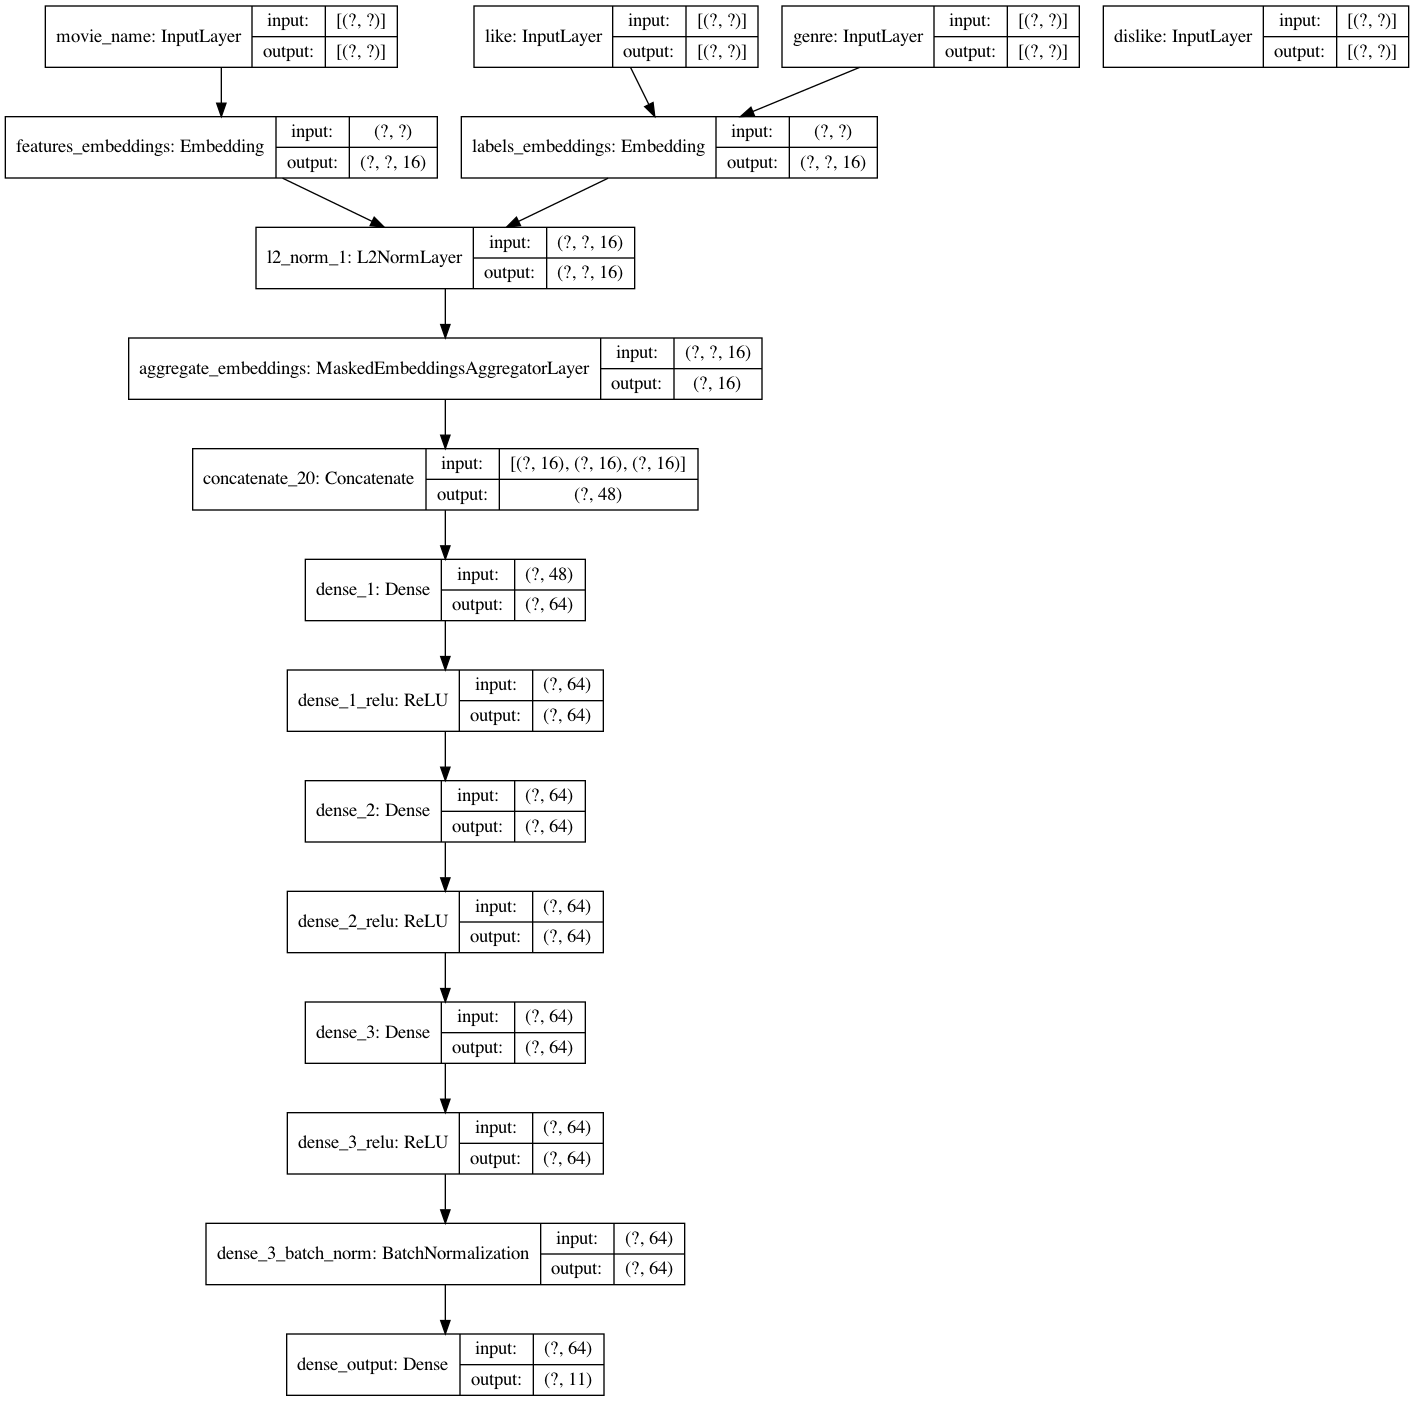

In [153]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [154]:
model.fit([tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['title_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['like']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['dislike']),
            tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['all_genres'])
           ],user_title_list_e['predict_labels'].values,
           steps_per_epoch=1, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 6/100
1/1 [==============================] - 0s 897us/step - loss: nan
Epoch 7/100
1/1 [==============================] - 0s 919us/step - loss: nan
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 9/100
1/1 [==============================] - 0s 809us/step - loss: nan
Epoch 10/100
1/1 [==============================] - 0s 808us/step - loss: nan
Epoch 11/100
1/1 [==============================] - 0s 936us/step - loss: nan
Epoch 12/100
1/1 [==============================] - 0s 1000us/step - loss: nan
Epoch 13/100
1/1 [==============================] - 0s 1ms/step - loss: nan
Epoch 14

In [155]:
tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['title_d'])

array([[0, 4, 5],
       [0, 0, 6],
       [0, 0, 6],
       [0, 0, 7],
       [0, 0, 8],
       [0, 5, 6],
       [2, 9, 4],
       [0, 0, 9],
       [0, 0, 9]], dtype=int32)

In [156]:
tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['title_d'])

array([[0, 4, 5],
       [0, 0, 6],
       [0, 0, 6],
       [0, 0, 7],
       [0, 0, 8],
       [0, 5, 6],
       [2, 9, 4],
       [0, 0, 9],
       [0, 0, 9]], dtype=int32)

In [157]:
model.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_name (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
like (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
genre (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
features_embeddings (Embedding) (None, None, 16)     176         movie_name[0][0]                 
______________________________________________________________________________________

In [151]:
results = model.evaluate([tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['title_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['like']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['dislike']),
            tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['all_genres'])
           ],user_title_list_e['predict_labels'].values, verbose=2)

1/1 - 0s - loss: nan
